<a href="https://colab.research.google.com/github/kghilothia06/Time-Series-Forecasting/blob/main/EXPONENTIAL_SMOOTHING_graphs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Grid Search Framework for ETS models for sales prediction

Import Libraries

In [1]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from pandas import read_excel
from numpy import array
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


one-step Holt Winter’s Exponential Smoothing forecast

In [2]:
def exp_smoothing_forecast(history, config):
    t,d,s,p,b,r = config
    # define model
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped=d, seasonal=s, seasonal_periods=p)
    # fit model
    model_fit = model.fit(optimized=True, use_boxcox=b, remove_bias=r)
    # make one step forecast
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

walk-forward validation for univariate data

In [3]:
def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    # split dataset
    train = data[:-n_test]
    test = data[-n_test:]
    # seed history with training dataset
    history = [x for x in train]
    # step over each time-step in the test set
    for i in range(len(test)):
        # fit model and make forecast for history
        yhat = exp_smoothing_forecast(history, cfg)
        # store forecast in list of predictions
        predictions.append(yhat)
        # add actual observation to history for the next loop
        history.append(test[i])
    # estimate prediction error
    #error = sqrt(mean_squared_error(test, predictions))
    #print('RMSE : ' + str(error))
    return train, test, predictions


Load dataset for monthly sales prediction

In [4]:
# load dataset
series = read_excel('/content/Sales-monthly.xlsx', header=0, index_col=0)
data = series.values
# data split
n_test = 12

specify model configs

In [5]:
t = None
d =False
s = 'add'
p = 12
b = True
r = False
cfg = [t,d,s,p,b,r]

In [6]:
train, test, predictions = walk_forward_validation(data,n_test,cfg)

## Adding Graph

reset columns

In [7]:
series.reset_index(level=0, inplace=True)

set x-axis labels

In [8]:
x_axis_label = []

for i in range(len(series)):
  if series.iloc[i,0][-2:] == '-1':
    x_axis_label.append(series.iloc[i,0][:-2])
  else:
    x_axis_label.append(' ')

x_axis_label

['2017',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2018',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2019',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '2020',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ']

separate dates for test and training data

In [9]:
dates_train = []
for i in range(len(series)-n_test):
  dates_train.append(series['Month'][i])

dates_train

['2017-1',
 '2017-2',
 '2017-3',
 '2017-4',
 '2017-5',
 '2017-6',
 '2017-7',
 '2017-8',
 '2017-9',
 '2017-10',
 '2017-11',
 '2017-12',
 '2018-1',
 '2018-2',
 '2018-3',
 '2018-4',
 '2018-5',
 '2018-6',
 '2018-7',
 '2018-8',
 '2018-9',
 '2018-10',
 '2018-11',
 '2018-12',
 '2019-1',
 '2019-2',
 '2019-3',
 '2019-4',
 '2019-5',
 '2019-6',
 '2019-7',
 '2019-8',
 '2019-9',
 '2019-10',
 '2019-11',
 '2019-12']

In [10]:
dates_test = []
for i in range(len(series)-n_test , len(series)):
  dates_test.append(series['Month'][i])

dates_test

['2020-1',
 '2020-2',
 '2020-3',
 '2020-4',
 '2020-5',
 '2020-6',
 '2020-7',
 '2020-8',
 '2020-9',
 '2020-10',
 '2020-11',
 '2020-12']

Set Prediction interval for each forecast

In [11]:
confidence_upper = []
confidence_lower = []
for i in predictions:
  confidence_upper.append(i+1.28*(array(predictions).std()))
  confidence_lower.append(i-1.28*(array(predictions).std()))

Plot graph

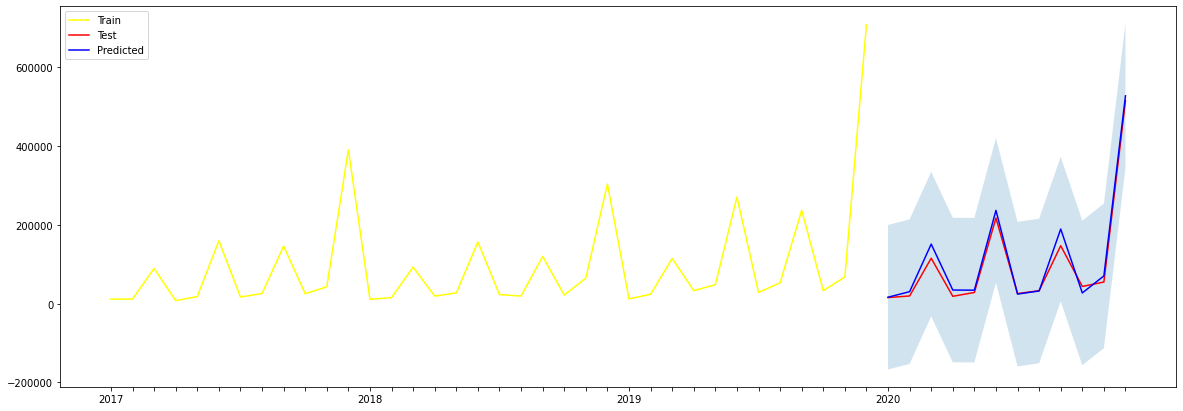

In [12]:
plt.figure(figsize=(20,7))
plt.plot(dates_train, train, color='yellow', label="Train")
plt.plot(dates_test, test, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()

Load dataset for quarterly sales prediction

In [13]:
# load dataset
series = read_excel('/content/Sales-quarterly.xlsx', header=0, index_col=0)
series = pd.DataFrame(series['Sales'])
data = series.values
# data split
n_test = 4

specify model configs

In [14]:
t = None
d = False
s = 'add'
p = 12
b = False
r = True
cfg = [t,d,s,p,b,r]

In [15]:
train, test, predictions = walk_forward_validation(data,n_test,cfg)

#Adding Graph

Reset columns

In [16]:
series.reset_index(level=0, inplace=True)

set x axis labels

In [17]:
x_axis_label = []
#dictionary to keep track of current year
vis = {}
vis[2017] = 0
vis[2018] = 0
vis[2019] = 0
vis[2020] = 0
for i in range(len(series)):
  if vis[int(series.iloc[i,0])] == 0:
    vis[int(series.iloc[i,0])] = 1
    x_axis_label.append(str(series.iloc[i,0]))
  else:
    x_axis_label.append(' ')

x_axis_label

['2017',
 ' ',
 ' ',
 ' ',
 '2018',
 ' ',
 ' ',
 ' ',
 '2019',
 ' ',
 ' ',
 ' ',
 '2020',
 ' ',
 ' ',
 ' ']

separate dates for training and test data

In [18]:
dates_train = []
for i in range(len(series)-n_test):
  dates_train.append(str(series['OPP_CLOSING_YEAR'][i]) + ' - ' + str(i%4))

dates_train

['2017 - 0',
 '2017 - 1',
 '2017 - 2',
 '2017 - 3',
 '2018 - 0',
 '2018 - 1',
 '2018 - 2',
 '2018 - 3',
 '2019 - 0',
 '2019 - 1',
 '2019 - 2',
 '2019 - 3']

In [19]:
dates_test = []
for i in range(len(series)-n_test , len(series)):
  dates_test.append(str(series['OPP_CLOSING_YEAR'][i]) + ' - ' + str(i%4))

dates_test

['2020 - 0', '2020 - 1', '2020 - 2', '2020 - 3']

Set prediction intervals for predictions

In [20]:
confidence_upper = []
confidence_lower = []
for i in predictions:
  confidence_upper.append(i+1.28*(array(predictions).std()))
  confidence_lower.append(i-1.28*(array(predictions).std()))

Plot graph

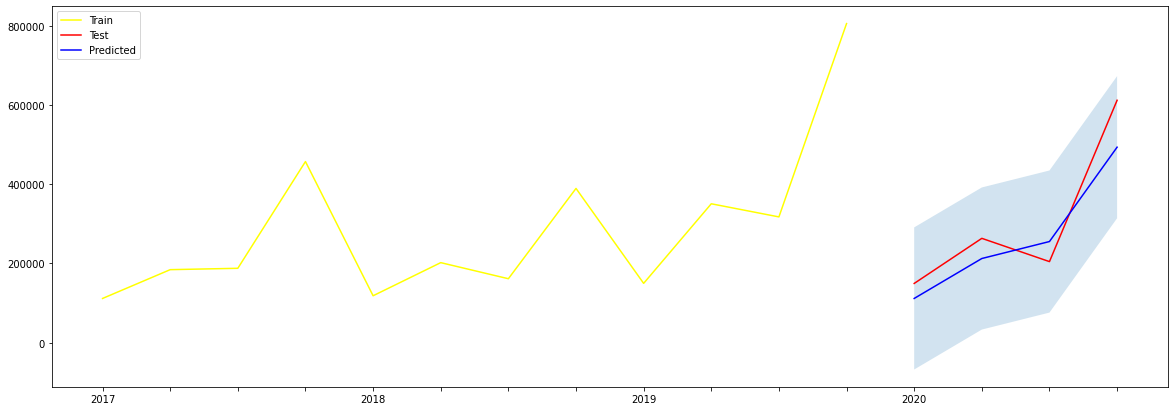

In [21]:
plt.figure(figsize=(20,7))
plt.plot(dates_train, train, color='yellow', label="Train")
plt.plot(dates_test, test, color='red', label="Test")
plt.plot(dates_test, predictions, color='blue', label="Predicted")
plt.legend(loc="upper left")
plt.fill_between(dates_test, confidence_upper, confidence_lower, alpha=0.2)
plt.xticks(np.arange(len(x_axis_label)), x_axis_label)

plt.show()